In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")



In [ ]:
# 1 Import Dataset & Basic EDA

df = pd.read_csv("../data/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


# Outliers are present. Will need to perform Winsorization here.

In [6]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [7]:
df.duplicated().sum()

np.int64(0)

In [10]:
num_col = df.columns[:-1]
target = "Outcome"

X = df.drop(target, axis  = 1)
y = df[target]

print(X.shape, y.shape)

(768, 8) (768,)


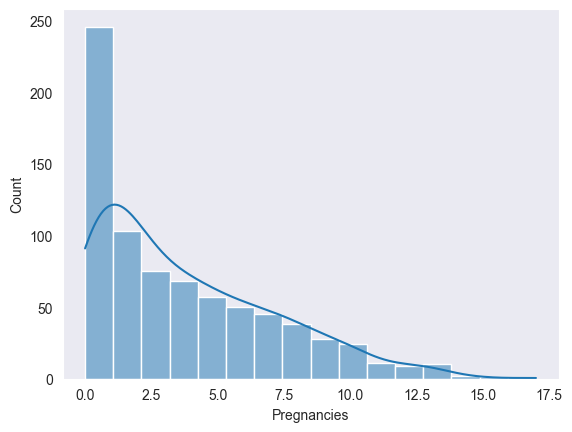

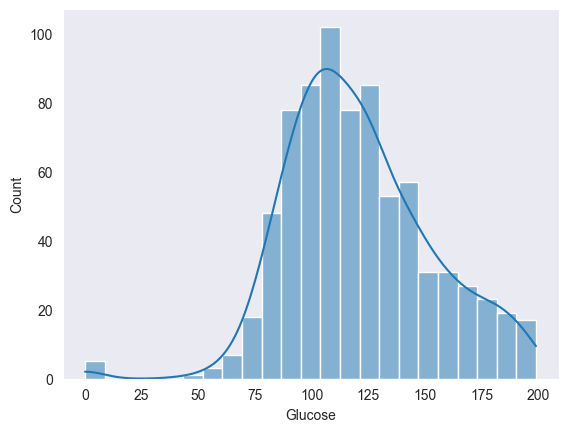

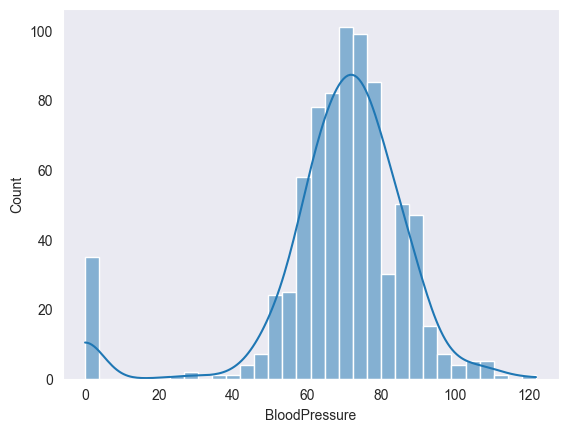

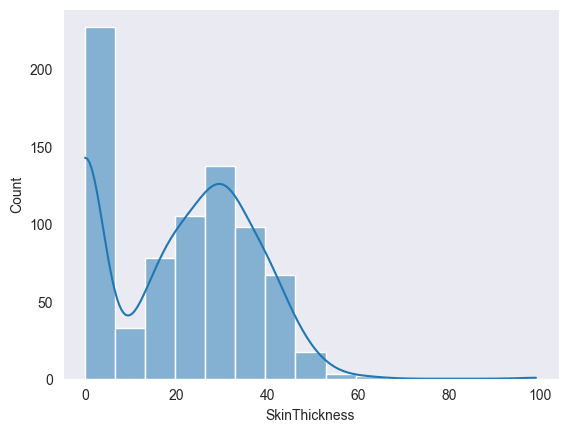

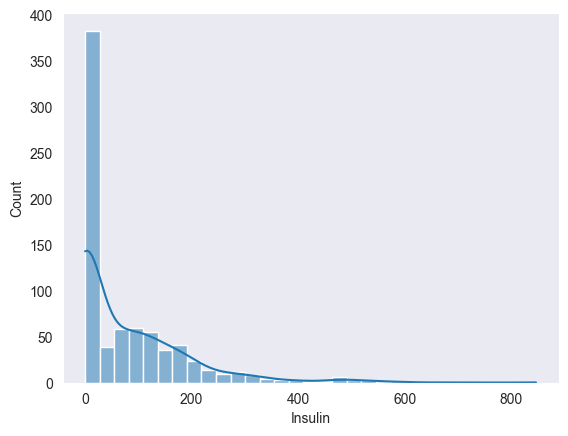

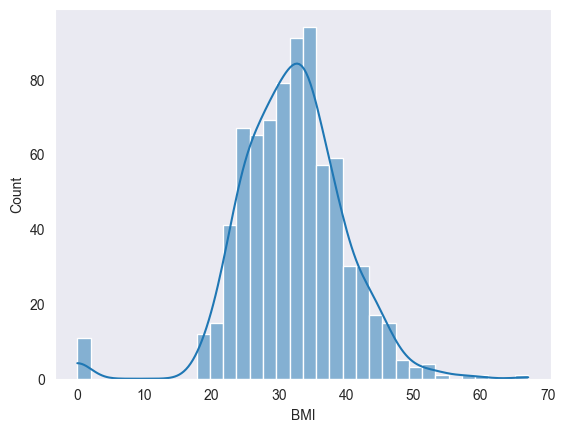

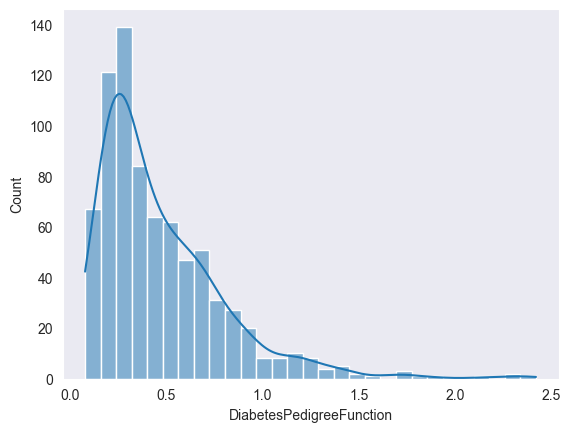

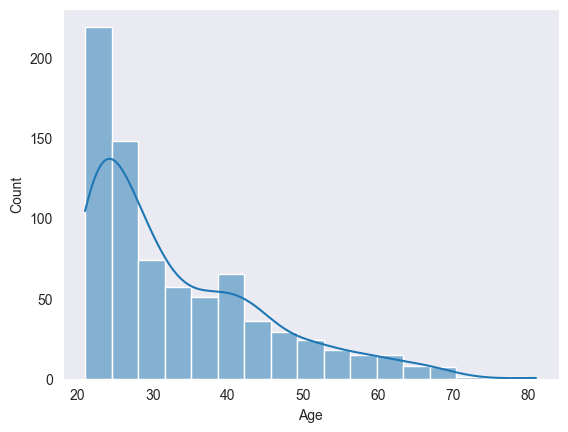

In [ ]:
# 2. Visualization of the numerical columns


for col in num_col:
    sns.histplot(X[col], kde = True)
    plt.show()


Outcome
0    500
1    268
Name: count, dtype: int64


<Axes: xlabel='Outcome', ylabel='count'>

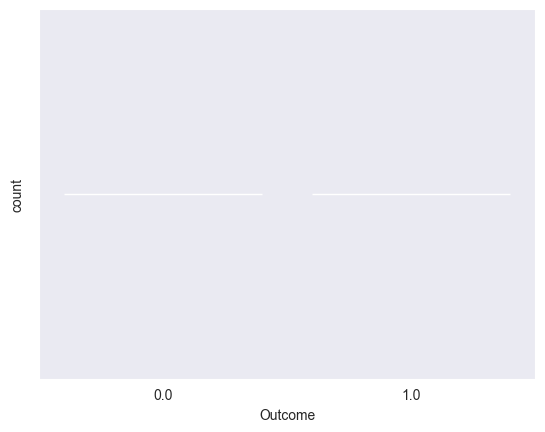

In [ ]:
# Visualise target:
print(y.value_counts())
sns.countplot(data = df, x = "Outcome")

In [14]:
# Right skewed: apply square transformation
remove_zero_mean_imputation = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]


for col in remove_zero_mean_imputation:
    df.loc[col, (df[df[col] == 0].index)] = np.nan

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y, shuffle=True)

print(X_train.shape, X_test.shape)

(537, 8) (231, 8)


In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, FunctionTransformer, PowerTransformer
from sklearn.impute import SimpleImputer

r_skewed = ["Pregnancies", "SkinThickness", "Insulin","DiabetesPedigreeFunction"] 


def win(X, perc = 2):
    lower, upper = np.percentile(X, perc), np.percentile(X, 100-perc)
    return np.clip(X, lower, upper)


num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("win", FunctionTransformer(func = win)),
    ("scaler", RobustScaler())    
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_col),
    ("r_skewed",FunctionTransformer(func=np.square), r_skewed)
], remainder="passthrough")


In [47]:
# 4. Modeling

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, f1_score, roc_auc_score, accuracy_score

models = {
    "dummy" : DummyClassifier(),
    "lin" : LogisticRegression(max_iter=10000),
    "rf" : RandomForestClassifier(max_depth=5)
}

estimator = DecisionTreeClassifier(random_state=42, max_depth=5)

for name, model in models.items():
    # Construct pipeline

    full_pipeline = Pipeline([
        ('pre_pr', preprocessor),
        ('selection', SelectFromModel(estimator)),
        ("model", model)
    ])

    cv_score = cross_val_score(full_pipeline, X_train, y_train, cv=3, scoring="roc_auc")

    print("=="*20, name, "=="*20)
    print(cv_score, np.mean(cv_score), np.var(cv_score))

    # Fit on all data:
    full_pipeline.fit(X_train, y_train)
    y_pred = full_pipeline.predict(X_test)
    y_p_pred = full_pipeline.predict_proba(X_test)[:, 1]

    print("Acc", accuracy_score(y_test, y_pred))
    print("F1", f1_score(y_test, y_pred))
    print("AUC",roc_auc_score(y_test, y_p_pred))



======================================== dummy ========================================
[0.5 0.5 0.5] 0.5 0.0
Acc 0.6493506493506493
F1 0.0
AUC 0.5
======================================== lin ========================================
[0.84797482 0.78990902 0.80328095] 0.8137215954234865 0.0006164432001213606
Acc 0.7445887445887446
F1 0.5874125874125874
AUC 0.8197530864197531
======================================== rf ========================================
[0.84510126 0.81279294 0.81761787] 0.825170688908175 0.00020249379221056637
Acc 0.7532467532467533
F1 0.6122448979591837
AUC 0.8233744855967078


In [ ]:
"lin" : LogisticRegression()

array([0.65176909, 0.34823091])

In [43]:
models["lin"].coef_

array([[1.44109133, 0.71197233, 0.41483391]])

In [44]:
models["rf"].feature_importances_

array([0.41956571, 0.32988012, 0.25055417])

In [46]:
models["rf"].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}